In [2]:
!pip install wfdb
!pip install hrv-analysis
!pip install py-ecg-detectors
!pip install neurokit2

from google.colab import output
output.clear()
print("Packages installed successfully")

Packages installed successfully


In [3]:
import pprint
import os
import datetime

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import wfdb
import hrvanalysis
import ecgdetectors
import hrv
import neurokit2 as nk

## MIT-BIH Normal Sinus Rhythm Database

https://physionet.org/content/nsrdb/1.0.0/

In [4]:
# !wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/ -P "/content/drive/MyDrive/Projects/HRV/dataset"

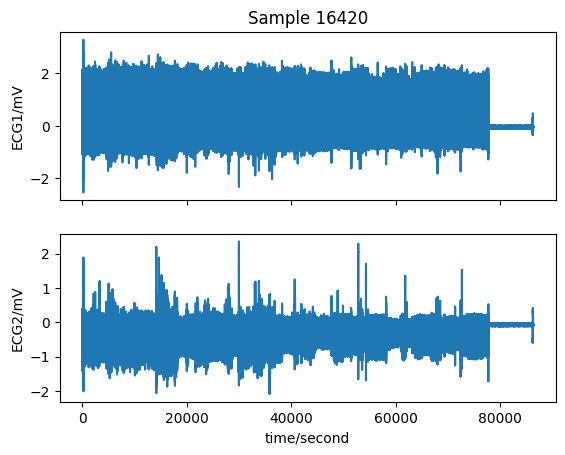

{'adc_gain': [200.0, 200.0],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'base_counter': None,
 'base_date': None,
 'base_time': datetime.time(9, 55),
 'baseline': [0, 0],
 'block_size': [0, 0],
 'byte_offset': [None, None],
 'checksum': [26371, 32741],
 'comments': ['38 F'],
 'counter_freq': None,
 'd_signal': None,
 'e_d_signal': None,
 'e_p_signal': None,
 'file_name': ['16420.dat', '16420.dat'],
 'fmt': ['212', '212'],
 'fs': 128,
 'init_value': [-19, -5],
 'n_sig': 2,
 'p_signal': array([[-0.095, -0.025],
       [-0.085, -0.035],
       [-0.085, -0.025],
       ...,
       [-0.07 , -0.075],
       [-0.07 , -0.075],
       [-0.07 , -0.075]]),
 'record_name': '16420',
 'samps_per_frame': [1, 1],
 'sig_len': 11051008,
 'sig_name': ['ECG1', 'ECG2'],
 'skew': [None, None],
 'units': ['mV', 'mV']}


In [5]:
NSRDB_DIR = "/content/drive/MyDrive/Projects/HRV/dataset/physionet.org/files/nsrdb/1.0.0/"
record = wfdb.rdrecord(os.path.join(NSRDB_DIR, "16420"))
wfdb.plot_wfdb(record=record, title="Sample 16420")
pprint.pprint(record.__dict__)

In [6]:
record_obj = wfdb.rdrecord(os.path.join(NSRDB_DIR, "16265"))
record_obj.__dict__

{'record_name': '16265',
 'n_sig': 2,
 'fs': 128,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 11730944,
 'base_time': datetime.time(8, 4),
 'base_date': None,
 'comments': ['32 M'],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.165, -0.325],
        [-0.155, -0.325],
        [-0.195, -0.305],
        ...,
        [-0.05 , -0.095],
        [-0.05 , -0.085],
        [-0.05 , -0.085]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['16265.dat', '16265.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-33, -65],
 'checksum': [15756, -21174],
 'block_size': [0, 0]}

In [ ]:
def slice_signal(record_obj, start_sec=0, end_sec=10, fs=250, _print=True):
    start = fs*start_sec
    end = fs*end_sec
    signal = record_obj.p_signal[start:end, 0]

    if _print:
        print("start        :", start)
        print("end          :", end)
        print("len(signal)  :", len(signal))
        print("seconds      :", end_sec - start_sec)

    # if len(signal) == 0:
    #     return signal, []

    detectors = ecgdetectors.Detectors(fs)
    r_peaks = detectors.two_average_detector(signal)
    if _print:
        print("len(r_peaks) :", len(r_peaks))
    return signal, r_peaks

def plot_signal(signal: np.array, r_peaks: list=None, figsize=(6, 4)):
    fig = plt.figure(figsize=figsize)
    plt.plot(signal)
    plt.gca().set_xlabel("")
    plt.gca().set_ylabel("mV")

    # ref: https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot
    if r_peaks:
        for xc in r_peaks:
            plt.axvline(x=xc, color='red', linestyle='--')

    plt.show()

In [ ]:
def rolling_slice(record_obj, start_sec=0, end_sec=20, size_sec=5, fs=250, _plot_signal=True, _print=True):
    full_r_peaks = []
    if end_sec == 'full':
        end_sec = len(record_obj.p_signal[:, 0]) // FS

    for _start_sec in range(start_sec, end_sec, size_sec):
        if _print:
            print(f"in range     : ({start_sec}, {end_sec}, {size_sec})")
            print("_start_sec   :", _start_sec)
            print("sig_len      :", len(record_obj.p_signal[:, 0]))

        signal, r_peaks = slice_signal(record_obj, start_sec=_start_sec, end_sec=_start_sec+size_sec, fs=fs, _print=_print)
        r_peaks = list(np.array(r_peaks) + _start_sec*fs)
        full_r_peaks += r_peaks
        if _plot_signal:
            plot_signal(signal, r_peaks)
        if _print:
            print(r_peaks)
    if _print:
        print("len(full_r_peaks):", len(full_r_peaks))
    return full_r_peaks

In [ ]:
start_time = datetime.datetime.now()

nsrdb = {}

START_SEC = 0
# END_SEC = 3600*18 # 18 jam
END_SEC = "full"
SIZE_SEC = 60 # 1 menit
FS = 128
_PLOT_SIGNAL = False
_PRINT = False
print("FS:", FS)
for record in wfdb.get_record_list("nsrdb"):
    try:
        print("Record:", record)
        record_obj = wfdb.rdrecord(os.path.join(NSRDB_DIR, record))
        print("  signal length          :", record_obj.sig_len)
        print("  recording time (hours) :", record_obj.sig_len / (3600*FS))
        print("  comments               :", record_obj.comments)

        r_peaks = rolling_slice(
            record_obj,
            start_sec=START_SEC,
            end_sec=END_SEC,
            size_sec=SIZE_SEC,
            fs=FS,
            _plot_signal=_PLOT_SIGNAL,
            _print=_PRINT,
        )
        # retrieve rr_interval from distance between 2 r_peak points
        rri = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks) - 1)]
        # convert the unit from freq_sample to milisecond
        rri = list(np.array(rri) * 1000 / FS)
        print("  len(r_peaks)           :", len(r_peaks))
        print("  len(rri)               :", len(rri))
        print("  recording time (secs)  :", record_obj.sig_len / FS)
        print("  r_peak / seconds       :", len(r_peaks) / (record_obj.sig_len / FS))

        RMSSD = hrv.HRV(FS).RMSSD(r_peaks)
        SDNN = hrv.HRV(FS).SDNN(r_peaks)
        print("  RMSSD                  :", RMSSD)
        print("  SDNN                   :", SDNN)

        nni = hrvanalysis.get_nn_intervals(rri)
        print("  len(nni)               :", len(nni))
        time_domain = hrvanalysis.extract_features.get_time_domain_features(nni)
        print("  time_domain Computed!")
        freq_domain = hrvanalysis.extract_features.get_frequency_domain_features(nni)
        print("  freq_domain Computed!")
        geom = hrvanalysis.extract_features.get_geometrical_features(nni)
        print("  geometrical features computed!")
        poincare = hrvanalysis.extract_features.get_poincare_plot_features(nni)
        print("  poincare features computed!")
        csi_cvi = hrvanalysis.extract_features.get_csi_cvi_features(nni)
        print("  csi cvi computed!")
        # Function computing the sample entropy of the given data
        # Must use this function on short term recordings, from 1 minute window
        if len(nni) <= 200:
            # Ref: https://ieeexplore.ieee.org/document/8295257
            # Sample entropy (SampEn), a popularly used “regularity analysis” tool,
            # has restrictions in handling shortterm segments (largely N ≤ 200) of
            # heart rate variability (HRV) data
            sampen = hrvanalysis.extract_features.get_sampen(nni)
            print("  sampen computed!")
        else:
            print("  nn > 200")
            print("  nn is set to NaN")
            sampen = {"sampen": np.nan}

        nsrdb[record] = {
            "id": "nsrdb-" + str(record),
            "db_source": "nsrdb",
            "age": record_obj.comments[0].split()[0],
            "gender": record_obj.comments[0].split()[1],
            "fs": FS,
            "signal_length": record_obj.sig_len,
            "recording_time_hours": record_obj.sig_len / (3600 * FS),
            "recording_time_seconds": record_obj.sig_len // FS,
            "rri_length": len(rri),
            "nni_length": len(nni),
            **time_domain,
            **freq_domain,
            **geom,
            **poincare,
            **csi_cvi,
            **sampen,
            "cardiac_info": "Sinus",
            "risk": 0,
        }
        print("  RECORD {} SAVED!".format(record))
        output.clear()
    except:
        print("\n ERROR (%s)\n" %record)

print("Running time:", datetime.datetime.now() - start_time)

Running time: 0:07:46.119224


In [ ]:
pprint.pprint(nsrdb[list(nsrdb.keys())[0]])

{'Modified_csi': 4763.005545065483,
 'age': '32',
 'cardiac_info': 'Sinus',
 'csi': 4.542879494286854,
 'cvi': 5.383768523984855,
 'cvnni': 0.24749744268978122,
 'cvsd': 0.10641253629728639,
 'db_source': 'nsrdb',
 'fs': 128,
 'gender': 'M',
 'hf': 2317.5203267649886,
 'hfnu': 35.39886811791506,
 'id': 'nsrdb-16265',
 'lf': 4229.356593268823,
 'lf_hf_ratio': 1.8249490821824008,
 'lfnu': 64.60113188208494,
 'max_hr': 196.92307692307693,
 'mean_hr': 83.725692248115,
 'mean_nni': 766.7945881646017,
 'median_nni': 750.0,
 'min_hr': 30.11764705882353,
 'nni_20': 76767,
 'nni_50': 43006,
 'nni_length': 118887,
 'pnni_20': 64.57194286963983,
 'pnni_50': 36.1741500260754,
 'range_nni': 1687.5,
 'ratio_sd2_sd1': 4.542879494286854,
 'recording_time_hours': 25.45777777777778,
 'recording_time_seconds': 91648,
 'risk': 0,
 'rmssd': 81.59655694562845,
 'rri_length': 118887,
 'sampen': nan,
 'sd1': 57.69772139540891,
 'sd2': 262.11379539427907,
 'sdnn': 189.7796996391029,
 'sdsd': 81.59655694181797,

In [ ]:
df_nsrdb = pd.DataFrame(nsrdb).T
df_nsrdb

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,rri_length,nni_length,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
16265,nsrdb-16265,nsrdb,32,M,128,11730944,25.457778,91648,118887,118887,...,None,57.697721,262.113795,4.542879,4.542879,5.383769,4763.005545,NaN,Sinus,0
16272,nsrdb-16272,nsrdb,20,F,128,11520000,25.0,90000,102216,102216,...,None,54.85214,253.008846,4.612561,4.612561,5.346449,4668.075042,NaN,Sinus,0
16273,nsrdb-16273,nsrdb,28,F,128,11354112,24.64,88704,113133,113133,...,None,72.457478,250.844904,3.46196,3.46196,5.463608,3473.660311,NaN,Sinus,0
16420,nsrdb-16420,nsrdb,38,F,128,11051008,23.982222,86336,115743,115743,...,None,43.164004,176.922205,4.098837,4.098837,5.087024,2900.700908,NaN,Sinus,0
16483,nsrdb-16483,nsrdb,42,M,128,11960320,25.955556,93440,132335,132335,...,None,54.967811,178.681349,3.250654,3.250654,5.196308,2323.325146,NaN,Sinus,0
16539,nsrdb-16539,nsrdb,35,F,128,11327488,24.582222,88496,114381,114381,...,None,61.940527,208.02176,3.358411,3.358411,5.314204,2794.490423,NaN,Sinus,0
16773,nsrdb-16773,nsrdb,26,M,128,11046912,23.973333,86304,96702,96702,...,None,84.294954,352.858255,4.185995,4.185995,5.677522,5908.25158,NaN,Sinus,0
16786,nsrdb-16786,nsrdb,32,F,128,11284480,24.488889,88160,108123,108123,...,None,47.352639,187.161534,3.952505,3.952505,5.151681,2959.027472,NaN,Sinus,0
16795,nsrdb-16795,nsrdb,20,F,128,10866688,23.582222,84896,103254,103254,...,None,61.070361,319.100234,5.225124,5.225124,5.493878,6669.353668,NaN,Sinus,0
17052,nsrdb-17052,nsrdb,45,F,128,10659840,23.133333,83280,98798,98798,...,None,58.900207,258.133086,4.38255,4.38255,5.38608,4525.124338,NaN,Sinus,0


In [ ]:
df_nsrdb.to_csv("df_nsrdb_two_average.csv", index=False)
df_nsrdb.to_excel("df_nsrdb_two_average.xlsx", index=False)

In [ ]:
pd.read_csv("df_nsrdb_two_average.csv")

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,rri_length,nni_length,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,nsrdb-16265,nsrdb,32,M,128,11730944,25.457778,91648,118887,118887,...,NaN,57.697721,262.113795,4.542879,4.542879,5.383769,4763.005545,NaN,Sinus,0
1,nsrdb-16272,nsrdb,20,F,128,11520000,25.000000,90000,102216,102216,...,NaN,54.852140,253.008846,4.612561,4.612561,5.346449,4668.075042,NaN,Sinus,0
2,nsrdb-16273,nsrdb,28,F,128,11354112,24.640000,88704,113133,113133,...,NaN,72.457478,250.844904,3.461960,3.461960,5.463608,3473.660311,NaN,Sinus,0
3,nsrdb-16420,nsrdb,38,F,128,11051008,23.982222,86336,115743,115743,...,NaN,43.164004,176.922205,4.098837,4.098837,5.087024,2900.700908,NaN,Sinus,0
4,nsrdb-16483,nsrdb,42,M,128,11960320,25.955556,93440,132335,132335,...,NaN,54.967811,178.681349,3.250654,3.250654,5.196308,2323.325146,NaN,Sinus,0
5,nsrdb-16539,nsrdb,35,F,128,11327488,24.582222,88496,114381,114381,...,NaN,61.940527,208.021760,3.358411,3.358411,5.314204,2794.490423,NaN,Sinus,0
6,nsrdb-16773,nsrdb,26,M,128,11046912,23.973333,86304,96702,96702,...,NaN,84.294954,352.858255,4.185995,4.185995,5.677522,5908.251580,NaN,Sinus,0
7,nsrdb-16786,nsrdb,32,F,128,11284480,24.488889,88160,108123,108123,...,NaN,47.352639,187.161534,3.952505,3.952505,5.151681,2959.027472,NaN,Sinus,0
8,nsrdb-16795,nsrdb,20,F,128,10866688,23.582222,84896,103254,103254,...,NaN,61.070361,319.100234,5.225124,5.225124,5.493878,6669.353668,NaN,Sinus,0
9,nsrdb-17052,nsrdb,45,F,128,10659840,23.133333,83280,98798,98798,...,NaN,58.900207,258.133086,4.382550,4.382550,5.386080,4525.124338,NaN,Sinus,0


In [ ]:
pd.read_excel("df_nsrdb_two_average.xlsx")

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,rri_length,nni_length,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,nsrdb-16265,nsrdb,32,M,128,11730944,25.457778,91648,118887,118887,...,NaN,57.697721,262.113795,4.542879,4.542879,5.383769,4763.005545,NaN,Sinus,0
1,nsrdb-16272,nsrdb,20,F,128,11520000,25.000000,90000,102216,102216,...,NaN,54.852140,253.008846,4.612561,4.612561,5.346449,4668.075042,NaN,Sinus,0
2,nsrdb-16273,nsrdb,28,F,128,11354112,24.640000,88704,113133,113133,...,NaN,72.457478,250.844904,3.461960,3.461960,5.463608,3473.660311,NaN,Sinus,0
3,nsrdb-16420,nsrdb,38,F,128,11051008,23.982222,86336,115743,115743,...,NaN,43.164004,176.922205,4.098837,4.098837,5.087024,2900.700908,NaN,Sinus,0
4,nsrdb-16483,nsrdb,42,M,128,11960320,25.955556,93440,132335,132335,...,NaN,54.967811,178.681349,3.250654,3.250654,5.196308,2323.325146,NaN,Sinus,0
5,nsrdb-16539,nsrdb,35,F,128,11327488,24.582222,88496,114381,114381,...,NaN,61.940527,208.021760,3.358411,3.358411,5.314204,2794.490423,NaN,Sinus,0
6,nsrdb-16773,nsrdb,26,M,128,11046912,23.973333,86304,96702,96702,...,NaN,84.294954,352.858255,4.185995,4.185995,5.677522,5908.251580,NaN,Sinus,0
7,nsrdb-16786,nsrdb,32,F,128,11284480,24.488889,88160,108123,108123,...,NaN,47.352639,187.161534,3.952505,3.952505,5.151681,2959.027472,NaN,Sinus,0
8,nsrdb-16795,nsrdb,20,F,128,10866688,23.582222,84896,103254,103254,...,NaN,61.070361,319.100234,5.225124,5.225124,5.493878,6669.353668,NaN,Sinus,0
9,nsrdb-17052,nsrdb,45,F,128,10659840,23.133333,83280,98798,98798,...,NaN,58.900207,258.133086,4.382550,4.382550,5.386080,4525.124338,NaN,Sinus,0


## Uses Defined Annotation

In [ ]:
from google.colab import output

DATABASE = "nsrdb"

start_time = datetime.datetime.now()

FS = 128

nsrdb = {}
errs = []
for record in wfdb.get_record_list(DATABASE):
    print("New Record:", record)
    ann = wfdb.rdann(os.path.join(NSRDB_DIR, record), extension='atr')
    record_hea = wfdb.rdheader(os.path.join(NSRDB_DIR, record))
    record_obj = wfdb.rdrecord(os.path.join(NSRDB_DIR, record))

    r_peaks = np.array(ann.sample, dtype=np.float32)
    annotation = np.array(ann.symbol)

    # counting ectopic beats
    abnormal_beat_num = 0
    for _sym, _count in np.transpose(np.unique(annotation, return_counts=True)):
        if _sym != 'N':
            abnormal_beat_num += int(_count)
        if _sym == 'N':
            normal_beat_num = int(_count)
    normal_beats_ratio = normal_beat_num / (normal_beat_num + abnormal_beat_num)

    # check & replace ectopic beat with np.nan
    for idx, ann in enumerate(annotation):
        if str(ann).upper() != 'N':
            r_peaks[idx] = np.nan
    # interpolate
    r_peaks = hrvanalysis.preprocessing.interpolate_nan_values(r_peaks)

    # retrieve rr_interval from distance between 2 r_peak points
    rri = [r_peaks[i+1] - r_peaks[i] for i in range(len(r_peaks) - 1)]
    # convert the unit from freq_sample to milisecond
    rri = list(np.array(rri) * 1000 / FS)
    print("  len(r_peaks)           :", len(r_peaks))
    print("  len(rri)               :", len(rri))

    id = "{0}-{1}".format(DATABASE, record)
    try:
        rri = hrvanalysis.preprocessing.remove_outliers(
            rri,
            low_rri = 300,
            high_rri = 2000,
        )
        nni = hrvanalysis.preprocessing.interpolate_nan_values(rri)

        # remove nan values if exists
        nni = [val for val in nni if np.isfinite(val)]
        print("  len(nni)               :", len(nni))
        time_domain = hrvanalysis.extract_features.get_time_domain_features(nni)
        print("  time_domain computed!")
        freq_domain = hrvanalysis.extract_features.get_frequency_domain_features(nni)
        print("  freq_domain computed!")
        geom = hrvanalysis.extract_features.get_geometrical_features(nni)
        print("  geometrical features computed!")
        poincare = hrvanalysis.extract_features.get_poincare_plot_features(nni)
        print("  poincare features computed!")
        csi_cvi = hrvanalysis.extract_features.get_csi_cvi_features(nni)
        print("  csi cvi computed!")
        # Function computing the sample entropy of the given data.
        # Must use this function on short term recordings, from 1 minute window.
        if len(nni) <= 200:
            # Ref: https://ieeexplore.ieee.org/document/8295257
            # Sample entropy (SampEn), a popularly used “regularity analysis” tool,
            # has restrictions in handling shortterm segments (largely N ≤ 200) of
            # heart rate variability (HRV) data
            sampen = hrvanalysis.extract_features.get_sampen(nni)
            print("  sampen computed!")
        else:
            print("  nn > 200")
            print("  nn is set to NaN")
            sampen = {"sampen": np.nan}

        nsrdb[id] = {
            "id": id,
            "db_source": DATABASE,
            "age": record_obj.comments[0].split()[0],
            "gender": record_obj.comments[0].split()[1],
            "fs": FS,
            "signal_length": record_obj.sig_len,
            "recording_time_hours": record_obj.sig_len / (3600 * FS),
            "recording_time_seconds": record_obj.sig_len // FS,
            "normal_beats": normal_beat_num,
            "abnormal_beats": abnormal_beat_num,
            "normal_beats_ratio": normal_beats_ratio,
            "rri_length": len(rri),
            "nni_length": len(nni),
            **time_domain,
            **freq_domain,
            **geom,
            **poincare,
            **csi_cvi,
            **sampen,
            "cardiac_info": "Sinus",
            "risk": 0,
        }
        print("  RECORD {} SAVED!\n".format(id))
    except:
        print("  \nERROR at {}\n".format(id))
        errs.append(id)
    finally:
        output.clear()

print("\n"+"="*50)
print(datetime.datetime.now() - start_time)
print("error nums   :", len(errs))


0:01:49.069274
error nums   : 0


In [ ]:
df_nsrdb = pd.DataFrame(nsrdb).T
df_nsrdb.sample(2)

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,normal_beats,abnormal_beats,...,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
nsrdb-16483,nsrdb-16483,nsrdb,42,M,128,11960320,25.955556,93440,104330,231,...,None,18.976168,127.730461,6.731099,6.731099,4.588623,3439.065461,NaN,Sinus,0
nsrdb-19090,nsrdb-19090,nsrdb,45,M,128,11143168,24.182222,87056,81382,571,...,None,27.554559,150.214394,5.451526,5.451526,4.821025,3275.590733,NaN,Sinus,0


In [ ]:
df_nsrdb.to_csv("df_nsrdb.csv", index=False)
df_nsrdb.to_excel("df_nsrdb.xlsx", index=False)

In [ ]:
pd.set_option("display.max_columns", None)

In [ ]:
pd.read_csv("df_nsrdb.csv")

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,normal_beats,abnormal_beats,normal_beats_ratio,rri_length,nni_length,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,triangular_index,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,nsrdb-16265,nsrdb,32,M,128,11730944,25.457778,91648,100216,739,0.992680,100954,100953,793.960780,173.963853,49.726065,18874,18.696014,53569,53.063832,49.726065,773.43750,1246.09375,0.062630,0.219109,79.431139,199.480519,38.787879,18.380117,1837.443070,624.820659,2.940753,74.624137,25.375863,4497.628863,2035.365134,39.129070,NaN,35.161812,243.496389,6.925024,6.925024,5.136684,6744.873211,NaN,Sinus,0
1,nsrdb-16272,nsrdb,20,F,128,11520000,25.000000,90000,87757,9389,0.903352,97145,97144,870.012157,191.784737,75.018839,8021,8.256900,36736,37.816415,75.018839,921.87500,1519.53125,0.086227,0.220439,74.037080,199.480519,32.961373,24.381526,1756.983247,1167.675939,1.504684,60.074803,39.925197,5240.655131,2315.995944,42.035482,NaN,53.046603,265.986519,5.014205,5.014205,5.353637,5334.843286,NaN,Sinus,0
2,nsrdb-16273,nsrdb,28,F,128,11354112,24.640000,88704,89840,257,0.997148,90096,90096,825.731936,148.801818,64.251634,18710,20.766968,51126,56.746767,64.251634,820.31250,1152.34375,0.077812,0.180206,75.193854,199.480519,41.290323,14.902796,1682.483679,1002.835987,1.677726,62.654875,37.345125,4408.407314,1723.087649,20.716487,NaN,45.433018,205.474580,4.522583,4.522583,5.174250,3717.103066,NaN,Sinus,0
3,nsrdb-16420,nsrdb,38,F,128,11051008,23.982222,86336,102061,375,0.996339,102435,102435,759.808202,104.863547,34.798431,7561,7.381338,45160,44.086924,34.798431,765.62500,855.46875,0.045799,0.138013,80.738363,199.480519,51.891892,13.444428,593.425010,241.359052,2.458681,71.087247,28.912753,1685.178198,850.394136,15.450226,NaN,24.606327,146.243823,5.943342,5.943342,4.760244,3476.708385,NaN,Sinus,0
4,nsrdb-16483,nsrdb,42,M,128,11960320,25.955556,93440,104330,231,0.997791,104560,104560,728.096420,91.310366,26.836225,3078,2.943792,24414,23.349496,26.836225,726.56250,824.21875,0.036858,0.125410,83.820621,199.480519,53.333333,11.660883,635.419516,114.355923,5.556507,84.747977,15.252023,1209.478216,459.702777,17.001626,NaN,18.976168,127.730461,6.731099,6.731099,4.588623,3439.065461,NaN,Sinus,0
5,nsrdb-16539,nsrdb,35,F,128,11327488,24.582222,88496,108265,409,0.996236,108673,108673,779.746709,153.634737,91.738777,34913,32.126951,66839,61.505264,91.738777,765.62500,1160.15625,0.117652,0.197032,79.923305,199.480519,41.069519,16.159429,2956.967613,3300.599943,0.895888,47.254266,52.745734,8180.373321,1922.805765,25.308104,NaN,64.869409,207.362544,3.196615,3.196615,5.332890,2651.433092,NaN,Sinus,0
6,nsrdb-16773,nsrdb,26,M,128,11046912,23.973333,86304,81962,30935,0.725989,112896,112895,692.507142,180.577791,131.853613,26050,23.074743,52081,46.132655,131.853613,683.59375,1378.90625,0.190400,0.260759,93.012048,199.480519,35.720930,26.101338,4737.859771,4854.517860,0.975969,49.391923,50.608077,12301.297628,2708.919996,36.701886,NaN,93.234997,237.747581,2.549982,2.549982,5.549815,2425.008392,NaN,Sinus,0
7,nsrdb-16786,nsrdb,32,F,128,11284480,24.488889,88160,101605,134,0.998683,101738,101737,826.182223,117.593054,38.929637,14988,14.732248,55704,54.753480,38.929637,828.12500,1070.31250,0.047120,0.142333,74.199860,196.923077,43.636364,11.419426,692.301472,412.769205,1.677212,62.647710,37.352290,1784.608700,679.538023,22.991412,NaN,27.527546,164.007582,5.957944,5.957944,4.858751,3908.592116,NaN,Sinus,0
8,nsrdb-16795,nsrdb,20,F,128,10866688,23.582222,84896,86872,806,0.990807,87677,87677,852.793626,215.339789,85.042505,28344,32.328117,56025,63.900041,85.042505,796.87500,1347.65625,0.099722,0.252511,74.913581,199.480519,36.398104,19.160000,2152.753099,1957.293662,1.099862,52.377825,47.622175,6008.246827,1898.200067,42.071497,NaN,60.134475,298.540273,4.964544,4.964544,5.4582

In [ ]:
pd.read_excel("df_nsrdb.xlsx")

,id,db_source,age,gender,fs,signal_length,recording_time_hours,recording_time_seconds,normal_beats,abnormal_beats,normal_beats_ratio,rri_length,nni_length,mean_nni,sdnn,sdsd,nni_50,pnni_50,nni_20,pnni_20,rmssd,median_nni,range_nni,cvsd,cvnni,mean_hr,max_hr,min_hr,std_hr,lf,hf,lf_hf_ratio,lfnu,hfnu,total_power,vlf,triangular_index,tinn,sd1,sd2,ratio_sd2_sd1,csi,cvi,Modified_csi,sampen,cardiac_info,risk
0,nsrdb-16265,nsrdb,32,M,128,11730944,25.457778,91648,100216,739,0.992680,100954,100953,793.960780,173.963853,49.726065,18874,18.696014,53569,53.063832,49.726065,773.43750,1246.09375,0.062630,0.219109,79.431139,199.480519,38.787879,18.380117,1837.443070,624.820659,2.940753,74.624137,25.375863,4497.628863,2035.365134,39.129070,NaN,35.161812,243.496389,6.925024,6.925024,5.136684,6744.873211,NaN,Sinus,0
1,nsrdb-16272,nsrdb,20,F,128,11520000,25.000000,90000,87757,9389,0.903352,97145,97144,870.012157,191.784737,75.018839,8021,8.256900,36736,37.816415,75.018839,921.87500,1519.53125,0.086227,0.220439,74.037080,199.480519,32.961373,24.381526,1756.983247,1167.675939,1.504684,60.074803,39.925197,5240.655131,2315.995944,42.035482,NaN,53.046603,265.986519,5.014205,5.014205,5.353637,5334.843286,NaN,Sinus,0
2,nsrdb-16273,nsrdb,28,F,128,11354112,24.640000,88704,89840,257,0.997148,90096,90096,825.731936,148.801818,64.251634,18710,20.766968,51126,56.746767,64.251634,820.31250,1152.34375,0.077812,0.180206,75.193854,199.480519,41.290323,14.902796,1682.483679,1002.835987,1.677726,62.654875,37.345125,4408.407314,1723.087649,20.716487,NaN,45.433018,205.474580,4.522583,4.522583,5.174250,3717.103066,NaN,Sinus,0
3,nsrdb-16420,nsrdb,38,F,128,11051008,23.982222,86336,102061,375,0.996339,102435,102435,759.808202,104.863547,34.798431,7561,7.381338,45160,44.086924,34.798431,765.62500,855.46875,0.045799,0.138013,80.738363,199.480519,51.891892,13.444428,593.425010,241.359052,2.458681,71.087247,28.912753,1685.178198,850.394136,15.450226,NaN,24.606327,146.243823,5.943342,5.943342,4.760244,3476.708385,NaN,Sinus,0
4,nsrdb-16483,nsrdb,42,M,128,11960320,25.955556,93440,104330,231,0.997791,104560,104560,728.096420,91.310366,26.836225,3078,2.943792,24414,23.349496,26.836225,726.56250,824.21875,0.036858,0.125410,83.820621,199.480519,53.333333,11.660883,635.419516,114.355923,5.556507,84.747977,15.252023,1209.478216,459.702777,17.001626,NaN,18.976168,127.730461,6.731099,6.731099,4.588623,3439.065461,NaN,Sinus,0
5,nsrdb-16539,nsrdb,35,F,128,11327488,24.582222,88496,108265,409,0.996236,108673,108673,779.746709,153.634737,91.738777,34913,32.126951,66839,61.505264,91.738777,765.62500,1160.15625,0.117652,0.197032,79.923305,199.480519,41.069519,16.159429,2956.967613,3300.599943,0.895888,47.254266,52.745734,8180.373321,1922.805765,25.308104,NaN,64.869409,207.362544,3.196615,3.196615,5.332890,2651.433092,NaN,Sinus,0
6,nsrdb-16773,nsrdb,26,M,128,11046912,23.973333,86304,81962,30935,0.725989,112896,112895,692.507142,180.577791,131.853613,26050,23.074743,52081,46.132655,131.853613,683.59375,1378.90625,0.190400,0.260759,93.012048,199.480519,35.720930,26.101338,4737.859771,4854.517860,0.975969,49.391923,50.608077,12301.297628,2708.919996,36.701886,NaN,93.234997,237.747581,2.549982,2.549982,5.549815,2425.008392,NaN,Sinus,0
7,nsrdb-16786,nsrdb,32,F,128,11284480,24.488889,88160,101605,134,0.998683,101738,101737,826.182223,117.593054,38.929637,14988,14.732248,55704,54.753480,38.929637,828.12500,1070.31250,0.047120,0.142333,74.199860,196.923077,43.636364,11.419426,692.301472,412.769205,1.677212,62.647710,37.352290,1784.608700,679.538023,22.991412,NaN,27.527546,164.007582,5.957944,5.957944,4.858751,3908.592116,NaN,Sinus,0
8,nsrdb-16795,nsrdb,20,F,128,10866688,23.582222,84896,86872,806,0.990807,87677,87677,852.793626,215.339789,85.042505,28344,32.328117,56025,63.900041,85.042505,796.87500,1347.65625,0.099722,0.252511,74.913581,199.480519,36.398104,19.160000,2152.753099,1957.293662,1.099862,52.377825,47.622175,6008.246827,1898.200067,42.071497,NaN,60.134475,298.540273,4.964544,4.964544,5.4582